
**A.**

The function envy_free_room_allocation_path_method implements the "heaviest path" method for computing an envy-free room allocation under a fixed rent constraint.

Internally, it performs the following steps:

* Optimal assignment: Uses the Hungarian algorithm to find a maximum-value matching between players and rooms.

* Grant computation via Bellman-Ford: For each player, it constructs a directed graph representing their valuations and uses the Bellman-Ford algorithm to compute the heaviest reachable path from that player to any room. The difference between the assigned value and this best reachable value defines the player's grant.
* Rent adjustment: The total sum of grants is adjusted so that the final prices sum exactly to the given rent by subtracting a uniform correction from all grants.
* Final pricing: The computed room prices are rounded and returned alongside the allocation.
* The function returns a structured list of (player, room, value, payment) tuples, which can be easily used for both automated testing (via doctests) and human-readable output, supported by the print_allocation() utility function.



In [34]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import networkx as nx

def envy_free_room_allocation_path_method(valuations: list[list[float]], rent: float):
    """
    >>> envy_free_room_allocation_path_method([[100, 80], [80, 100]], 180)
    [(0, 0, 100.0, 90), (1, 1, 100.0, 90)]

    >>> envy_free_room_allocation_path_method([[50, 50], [50, 50]], 100)
    [(0, 0, 50.0, 50), (1, 1, 50.0, 50)]

    >>> envy_free_room_allocation_path_method([[100, 100], [10, 10]], 110)
    [(0, 0, 100.0, 55), (1, 1, 10.0, 55)]

    >>> envy_free_room_allocation_path_method([[75]], 75)
    [(0, 0, 75.0, 75)]

    >>> envy_free_room_allocation_path_method([[70, 60], [65, 75]], 0)
    [(0, 0, 70.0, 0), (1, 1, 75.0, 0)]

    >>> envy_free_room_allocation_path_method([[30, 20], [25, 35]], 200)
    [(0, 0, 30.0, 100), (1, 1, 35.0, 100)]

    >>> envy_free_room_allocation_path_method([[40, 60], [40, 60]], 100)
    [(0, 1, 60.0, 60), (1, 0, 40.0, 40)]

    >>> envy_free_room_allocation_path_method([
    ...     [90, 70, 60],
    ...     [60, 90, 70],
    ...     [70, 60, 90]], rent=240)
    [(0, 0, 90.0, 80), (1, 1, 90.0, 80), (2, 2, 90.0, 80)]

    >>> envy_free_room_allocation_path_method([
    ...     [90, 30, 60],
    ...     [70, 80, 40],
    ...     [60, 40, 100]], rent=240)
    [(0, 0, 90.0, 80), (1, 1, 80.0, 80), (2, 2, 100.0, 80)]

    >>> envy_free_room_allocation_path_method([
    ...     [80, 70, 60, 90],
    ...     [90, 60, 70, 80],
    ...     [70, 80, 90, 60],
    ...     [60, 90, 80, 70]], rent=360)
    [(0, 3, 90.0, 90), (1, 0, 90.0, 90), (2, 2, 90.0, 90), (3, 1, 90.0, 90)]

    >>> envy_free_room_allocation_path_method([
    ...     [90, 80, 70, 60],
    ...     [60, 90, 80, 70],
    ...     [70, 60, 90, 80],
    ...     [80, 70, 60, 90]], rent=360)
    [(0, 0, 90.0, 90), (1, 1, 90.0, 90), (2, 2, 90.0, 90), (3, 3, 90.0, 90)]

    >>> envy_free_room_allocation_path_method([[150, 0], [140, 10]], rent=100)
    [(0, 0, 150.0, 115), (1, 1, 10.0, -15)]

    >>> envy_free_room_allocation_path_method([
    ...     [100, 90, 10],
    ...     [100, 85, 5],
    ...     [10, 10, 100]], 110)
    [(0, 1, 90.0, 30), (1, 0, 100.0, 40), (2, 2, 100.0, 40)]
    """

    num_players = len(valuations)
    valuations = np.array(valuations)
    # Step 1: Find a max value assignment using the Hungarian algorithm
    # We negate values because the algorithm minimizes cost
    cost_matrix = -valuations
    assigned_players, assigned_rooms = linear_sum_assignment(cost_matrix)
    assignments = list(zip(assigned_players, assigned_rooms))

    # Step 2: Build a directed graph where each player points to all rooms with edge weights as their valuations
    graph = nx.DiGraph()
    for player in range(num_players):
        for room in range(num_players):
            graph.add_edge(f'player{player}', f'room{room}', weight=valuations[player][room])

    # Step 3: Compute grants using Bellman-Ford to find the heaviest path from each player
    player_grants = np.zeros(num_players)

    for player, room in assignments:
        source_node = f'player{player}'

        try:
            # Run Bellman-Ford to find longest path from the player to any room
            lengths = nx.single_source_bellman_ford_path_length(
                graph,
                source=source_node,
                weight=lambda u, v, d: -d['weight']  # invert weights to find max
            )

            # Best value the player could reach by any path (we invert sign back)
            best_reachable_value = -min(lengths[to] for to in lengths if to.startswith('room'))
            actual_value = valuations[player][room]
            player_grants[player] = actual_value - best_reachable_value

        except nx.NetworkXUnbounded:
            print(f"Bellman-Ford found a negative cycle for player {player}")
            player_grants[player] = 0  # Fallback in case of cycle


    # Step 4: Adjust grants so the total payment equals the rent
    total_grants = np.sum(player_grants)
    correction = (total_grants - rent) / num_players
    room_prices = player_grants - correction

    results = []
    for player, room in assignments:
        value = valuations[player][room]
        payment = round(float(room_prices[player]))
        results.append((
            int(player),
            int(room),
            round(float(value), 6),
            round(float(room_prices[player]))
        ))
    return results

def print_allocation(result):
    for player, room, value, payment in result:
        print(f"Player {player} gets room {room} with value {int(value)}, and pays {payment}")

def check_envy_free(valuations, allocation):
    """
    Returns True if no envy exists; otherwise, prints who envies whom.
    """
    n = len(valuations)
    prices = [0] * n
    rooms = [0] * n
    for player, room, value, price in allocation:
        prices[room] = price
        rooms[player] = room

    envy_found = False
    for i in range(n):
        my_room = rooms[i]
        my_utility = valuations[i][my_room] - prices[my_room]
        for j in range(n):
            if j == my_room:
                continue
            alt_utility = valuations[i][j] - prices[j]
            if alt_utility > my_utility:
                print(f"Player {i} envies room {j}: {alt_utility} > own utility {my_utility}")
                envy_found = True
    return not envy_found


if __name__ == "__main__":
    import doctest
    doctest.testmod(verbose=True)

    examples = [
        {"name": "D1", "valuations": [[100, 80], [80, 100]], "rent": 180},
        {"name": "D2", "valuations": [[50, 50], [50, 50]], "rent": 100},
        {"name": "D3", "valuations": [[100, 100], [10, 10]], "rent": 110},
        {"name": "D4", "valuations": [[75]], "rent": 75},
        {"name": "D5", "valuations": [[70, 60], [65, 75]], "rent": 0},
        {"name": "D6", "valuations": [[30, 20], [25, 35]], "rent": 200},
        {"name": "D7", "valuations": [[40, 60], [40, 60]], "rent": 100},
        {"name": "D8", "valuations": [[90, 70, 60], [60, 90, 70], [70, 60, 90]], "rent": 240},
        {"name": "D9", "valuations": [[90, 30, 60], [70, 80, 40], [60, 40, 100]], "rent": 240},
        {"name": "D10", "valuations": [[80, 70, 60, 90], [90, 60, 70, 80],
                                       [70, 80, 90, 60], [60, 90, 80, 70]], "rent": 360},
        {"name": "D11", "valuations": [[90, 80, 70, 60], [60, 90, 80, 70],
                                       [70, 60, 90, 80], [80, 70, 60, 90]], "rent": 360},
        {"name": "D12", "valuations": [[150, 0], [140, 10]], "rent": 100},
        {"name": "D13", "valuations": [[100, 90, 10], [100, 85, 5], [10, 10, 100]], "rent": 110},
    ]
    for ex in examples:
        print(f"\n=== {ex['name']} ===")
        result = envy_free_room_allocation_path_method(ex["valuations"], ex["rent"])
        print_allocation(result)
        is_envy_free = check_envy_free(ex["valuations"], result)
        print("No Envy" if is_envy_free else "Envy Detected")



Trying:
    envy_free_lp([[100, 80], [80, 100]], 180)
Expecting:
    [(0, 0, 100.0, 90.0), (1, 1, 100.0, 90.0)]
ok
Trying:
    envy_free_lp([[50, 50], [50, 50]], 100)
Expecting:
    [(0, 0, 50.0, 50.0), (1, 1, 50.0, 50.0)]
ok
Trying:
    envy_free_lp([[100, 100], [10, 10]], 110)
Expecting:
    [(0, 0, 100.0, 55.0), (1, 1, 10.0, 55.0)]
ok
Trying:
    envy_free_lp([[75]], 75)
Expecting:
    [(0, 0, 75.0, 75.0)]
ok
Trying:
    envy_free_lp([[70, 60], [65, 75]], 0)
Expecting:
    [(0, 0, 70.0, -0.0), (1, 1, 75.0, 0.0)]
ok
Trying:
    envy_free_lp([[30, 20], [25, 35]], 200)
Expecting:
    [(0, 0, 30.0, 100.0), (1, 1, 35.0, 100.0)]
ok
Trying:
    envy_free_lp([[40, 60], [40, 60]], 100)
Expecting:
    [(0, 1, 60.0, 60.0), (1, 0, 40.0, 40.0)]
ok
Trying:
    envy_free_lp([
        [90, 70, 60],
        [60, 90, 70],
        [70, 60, 90]], rent=240)
Expecting:
    [(0, 0, 90.0, 80.0), (1, 1, 90.0, 80.0), (2, 2, 90.0, 80.0)]
ok
Trying:
    envy_free_lp([
        [90, 30, 60],
        [70, 80, 40]

**B.**

This function implements envy-free room allocation using linear programming (LP).

* It starts by computing an optimal assignment using the Hungarian algorithm, which maximizes the total valuation.
Then, it formulates an LP to determine room prices such that:

* Envy-freeness: Each player weakly prefers their assigned room (after payment) over any other.
Total rent constraint: The sum of all room prices equals the specified rent.
* The LP solver may return floating-point results with many decimal digits, which are then rounded to two decimal places to make the output readable and compatible with doctest.
This rounding can lead to tiny mismatches when comparing expected and actual results.

Additionally, for the same input, LP solvers may return different (but still valid) solutions.
These differences do not affect the correctness — all returned allocations satisfy both envy-freeness and the rent constraint.

To illustrate the precise (unrounded) result, the __main__ block includes an example that prints the raw LP output.

In [32]:
import numpy as np
import cvxpy as cp
from scipy.optimize import linear_sum_assignment

def envy_free_lp(valuations: list[list[float]], rent: float):
    """
    >>> envy_free_lp([[100, 80], [80, 100]], 180)
    [(0, 0, 100.0, 90.0), (1, 1, 100.0, 90.0)]

    >>> envy_free_lp([[50, 50], [50, 50]], 100)
    [(0, 0, 50.0, 50.0), (1, 1, 50.0, 50.0)]

    >>> envy_free_lp([[100, 100], [10, 10]], 110)
    [(0, 0, 100.0, 55.0), (1, 1, 10.0, 55.0)]

    >>> envy_free_lp([[75]], 75)
    [(0, 0, 75.0, 75.0)]

    >>> envy_free_lp([[70, 60], [65, 75]], 0)
    [(0, 0, 70.0, -0.0), (1, 1, 75.0, 0.0)]

    >>> envy_free_lp([[30, 20], [25, 35]], 200)
    [(0, 0, 30.0, 100.0), (1, 1, 35.0, 100.0)]

    >>> envy_free_lp([[40, 60], [40, 60]], 100)
    [(0, 1, 60.0, 60.0), (1, 0, 40.0, 40.0)]

    >>> envy_free_lp([
    ...     [90, 70, 60],
    ...     [60, 90, 70],
    ...     [70, 60, 90]], rent=240)
    [(0, 0, 90.0, 80.0), (1, 1, 90.0, 80.0), (2, 2, 90.0, 80.0)]

    >>> envy_free_lp([
    ...     [90, 30, 60],
    ...     [70, 80, 40],
    ...     [60, 40, 100]], rent=240)
    [(0, 0, 90.0, 86.67), (1, 1, 80.0, 68.23), (2, 2, 100.0, 85.1)]

    >>> envy_free_lp([
    ...     [80, 70, 60, 90],
    ...     [90, 60, 70, 80],
    ...     [70, 80, 90, 60],
    ...     [60, 90, 80, 70]], rent=360)
    [(0, 3, 90.0, 90.0), (1, 0, 90.0, 90.0), (2, 2, 90.0, 90.0), (3, 1, 90.0, 90.0)]

    >>> envy_free_lp([
    ...     [90, 80, 70, 60],
    ...     [60, 90, 80, 70],
    ...     [70, 60, 90, 80],
    ...     [80, 70, 60, 90]], rent=360)
    [(0, 0, 90.0, 90.0), (1, 1, 90.0, 90.0), (2, 2, 90.0, 90.0), (3, 3, 90.0, 90.0)]

    >>> envy_free_lp([[150, 0], [140, 10]], rent=100)
    [(0, 0, 150.0, 120.0), (1, 1, 10.0, -20.0)]

    """
    n = len(valuations)
    valuations = np.array(valuations)

    # Step 1: Find optimal assignment using Hungarian algorithm
    cost_matrix = -valuations
    players, rooms = linear_sum_assignment(cost_matrix)
    assignment = list(zip(players, rooms))

    # Step 2: Define LP variables (room prices)
    p = cp.Variable(n)

    constraints = []

    # Envy-freeness constraints
    for i, j in assignment:
        for k in range(n):
            constraints.append(valuations[i, j] - p[j] >= valuations[i, k] - p[k])

    # Total rent constraint
    constraints.append(cp.sum(p) == rent)

    # Solve LP
    problem = cp.Problem(cp.Minimize(0), constraints)
    result_status = problem.solve()

    # Check if solution exists
    if p.value is None or result_status in ["infeasible", "unbounded"]:
        return None  # No envy-free prices exist for this assignment

    prices = p.value
    results = []
    for i, j in assignment:
      results.append((
          int(i),
          int(j),
          float(valuations[i][j]),
          round(float(prices[j]), 2)
      ))

    return results

def print_allocation(allocation):
    if allocation is None:
        return
    print("\nFinal Allocation:")
    for player, room, value, price in allocation:
        print(f"Player {player} gets room {room} with value {value} and pays {price:.6f}")


if __name__ == "__main__":
  import doctest
  doctest.testmod(verbose=True)
  valuations = [
        [150, 10, 5],
        [140, 15, 10],
        [130, 20, 5]
    ]
  rent = 100

  allocation = envy_free_lp(valuations, rent)
  print("\n========Example of unrounded allocation========")
  print_allocation(allocation)


Trying:
    envy_free_lp([[100, 80], [80, 100]], 180)
Expecting:
    [(0, 0, 100.0, 90.0), (1, 1, 100.0, 90.0)]
ok
Trying:
    envy_free_lp([[50, 50], [50, 50]], 100)
Expecting:
    [(0, 0, 50.0, 50.0), (1, 1, 50.0, 50.0)]
ok
Trying:
    envy_free_lp([[100, 100], [10, 10]], 110)
Expecting:
    [(0, 0, 100.0, 55.0), (1, 1, 10.0, 55.0)]
ok
Trying:
    envy_free_lp([[75]], 75)
Expecting:
    [(0, 0, 75.0, 75.0)]
ok
Trying:
    envy_free_lp([[70, 60], [65, 75]], 0)
Expecting:
    [(0, 0, 70.0, -0.0), (1, 1, 75.0, 0.0)]
ok
Trying:
    envy_free_lp([[30, 20], [25, 35]], 200)
Expecting:
    [(0, 0, 30.0, 100.0), (1, 1, 35.0, 100.0)]
ok
Trying:
    envy_free_lp([[40, 60], [40, 60]], 100)
Expecting:
    [(0, 1, 60.0, 60.0), (1, 0, 40.0, 40.0)]
ok
Trying:
    envy_free_lp([
        [90, 70, 60],
        [60, 90, 70],
        [70, 60, 90]], rent=240)
Expecting:
    [(0, 0, 90.0, 80.0), (1, 1, 90.0, 80.0), (2, 2, 90.0, 80.0)]
ok
Trying:
    envy_free_lp([
        [90, 30, 60],
        [70, 80, 40]

**B - Runtime Comparison**

This part compares the runtime of the two methods for envy-free room allocation:

* For each input size n (number of players and rooms), it generates a random n × n valuation matrix and a random rent.
* Then it measures the execution time of each method using time.perf_counter().

* The function compare_allocation_methods returns lists of runtimes for both methods, which are then plotted using Matplotlib.
This visualization shows how the performance of each method scales with the number of players/rooms.

* Conclusion: The path-based method remains extremely fast and nearly constant in runtime, even as
n increases.
In contrast, the LP-based method becomes significantly slower as
n grows, with visible jumps and runtime variability due to solver complexity and internal precision.

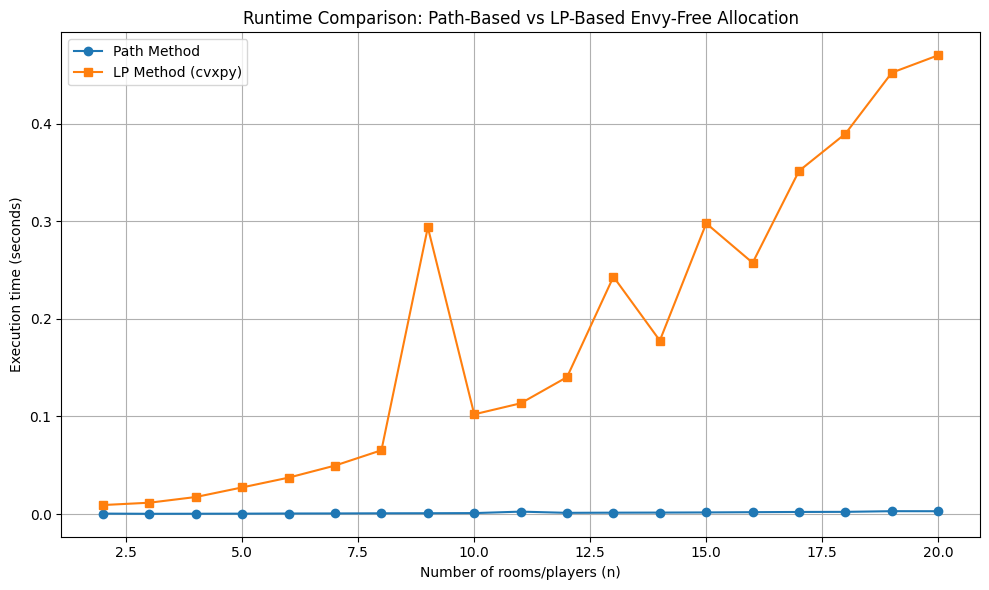

In [33]:
import time
import numpy as np
import matplotlib.pyplot as plt

def compare_allocation_methods(sizes):
    """
    Compare the execution time of the path-based method and the LP-based method
    for different numbers of players/rooms.

    Parameters:
        sizes (list[int]): List of input sizes (n = number of players/rooms)

    Returns:
        tuple: (sizes, path_times, lp_times)
    """
    path_times = []
    lp_times = []

    for n in sizes:
        # Generate random valuation matrix of size n x n
        valuations = np.random.randint(0, 100, size=(n, n)).tolist()
        rent = int(np.random.uniform(50, 150) * n)  # random rent per player

        # Time the path-based method
        start = time.perf_counter()
        envy_free_room_allocation_path_method(valuations, rent)
        path_times.append(time.perf_counter() - start)

        # Time the LP-based method
        start = time.perf_counter()
        envy_free_lp(valuations, rent)
        lp_times.append(time.perf_counter() - start)

    return sizes, path_times, lp_times

# Compare for input sizes from 2 to 20
sizes = list(range(2, 21))
sizes, path_times, lp_times = compare_allocation_methods(sizes)

plt.figure(figsize=(10, 6))
plt.plot(sizes, path_times, label="Path Method", marker='o')
plt.plot(sizes, lp_times, label="LP Method (cvxpy)", marker='s')
plt.xlabel("Number of rooms/players (n)")
plt.ylabel("Execution time (seconds)")
plt.title("Runtime Comparison: Path-Based vs LP-Based Envy-Free Allocation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
